In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.matplotlib.rcParams['savefig.dpi'] = 144
import seaborn

# Anomaly Detection, Session 2

##  Review of exercises

## Running averages and local models

- Most of the anomalies occur in the most recent year.  Underlying model may be changing
- **Moving Z-score**: Calculate moving window mean, std dev.  Use z-score within window.
- Exponential running average: Slowly forget past values.  (? Can we have exponential std dev?)

## Advanced detection algorithms

- Bayesian changepoint detection looks for abrupt changes in underlying model
- Can we find a better subset of the data to demonstrate this?  Perhaps localized data somehwere where a bike stand expanded?

Here's a toy model I've developed for this

In [2]:
import numpy as np
from scipy import stats

In [3]:
T = 1000
lambda_ = 200.
def hazard_func(r):
    return 1 / lambda_

mu0, kappa0, alpha0, beta0 = 0, 1, 1, 1

In [7]:
X = np.zeros(T)
CP = [0]

curr_ivar = np.random.gamma(alpha0) / beta0
curr_mean = (kappa0 * curr_ivar)**-0.5 * np.random.randn() + mu0
curr_run = 0

for t in range(T):
    p = hazard_func(curr_run)
    if np.random.rand() < p:
        curr_ivar = np.random.gamma(alpha0) / beta0
        curr_mean = (kappa0 * curr_ivar)**-0.5 * np.random.randn() + mu0
        curr_run = 0
        CP.append(t)
    else:
        curr_run += 1
    X[t] = curr_ivar**-0.5 * np.random.randn() + curr_mean

[0, 1000, 0, 1000]

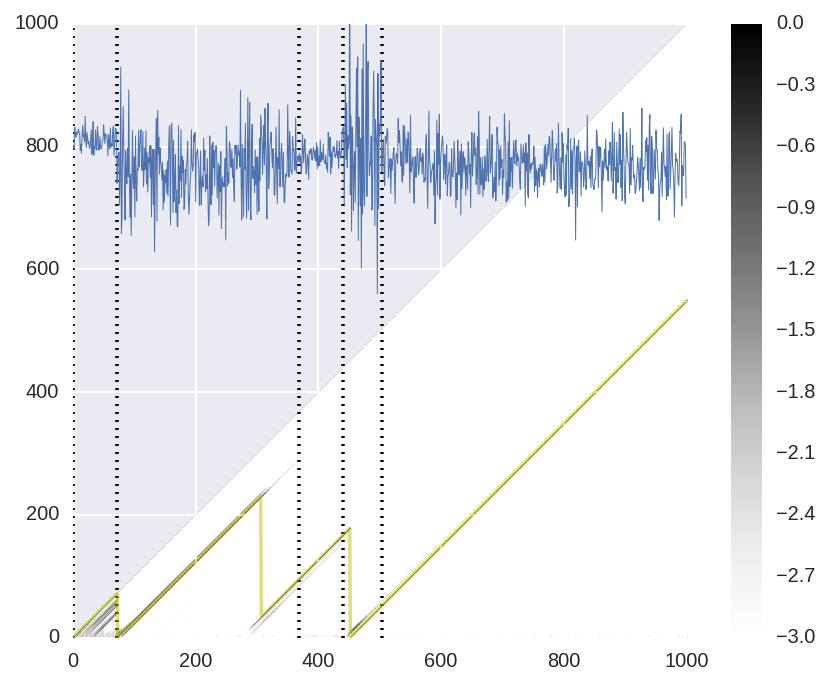

In [8]:
# From the matlab script
R = np.zeros([T+1, T+1])
R[0,0] = 1

muT = np.array(mu0)
kappaT = np.array(kappa0)
alphaT = np.array(alpha0)
betaT = np.array(beta0)

maxes = np.zeros(T+1)
for t in xrange(T):
    xt = (X[t] - muT) / np.sqrt(betaT * (kappaT+1) / (alphaT * kappaT))
    predprobs = stats.t.pdf(xt, 2 * alphaT)
    H = np.ones(t+1) * hazard_func(t)
    
    #print R[:t+1, t], predprobs, H
    #print t
    R[1:t+2, t+1] =  R[:t+1,t] * predprobs * (1 - H)
    R[0,     t+1] = (R[:t+1,t] * predprobs * H).sum()
    R[:,t+1] = R[:,t+1] / R[:,t+1].sum()  # Numerics -- but these sums aren't close to 1???
    
    muT0 = np.r_[mu0, (kappaT * muT + X[t]) / (kappaT + 1)]
    kappaT0 = np.r_[kappa0, kappaT + 1]
    alphaT0 = np.r_[alpha0, alphaT + 0.5]
    betaT0 = np.r_[beta0, betaT + (kappaT * (X[t] - muT)**2 / (2 * (kappaT + 1)))]
    
    muT = muT0
    kappaT = kappaT0
    alphaT = alphaT0
    betaT = betaT0

plt.imshow(np.log10(R), vmin=-3, origin='lower')
plt.colorbar()
plt.plot(X*20 + 800, lw=0.5)
plt.plot(R.argmax(axis=0), alpha=0.5, c='y')
plt.vlines(CP, 0, 1000, linestyles=':')
plt.axis([0,T,0,T])

Above shows probability of a run of length y at time x. Below, the probability that the run at x began at y.

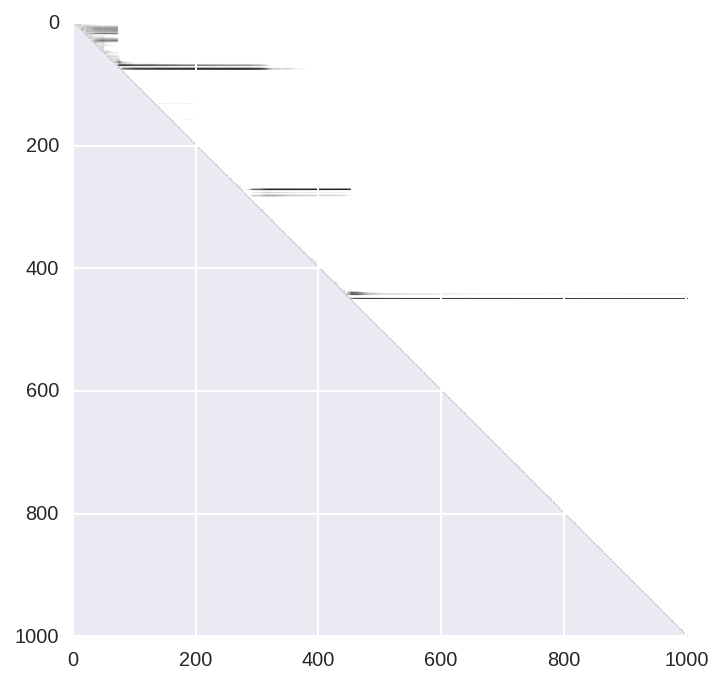

In [9]:
R2 = np.zeros([T+1, T+1])
R2[0,0] = R[0,0]
for i in xrange(1, T+1):
    R2[:i, i] = R[i-1::-1, i]
plt.imshow(np.log10(R2), vmin=-3, origin='upper')

Probability that we just passed a changepoint

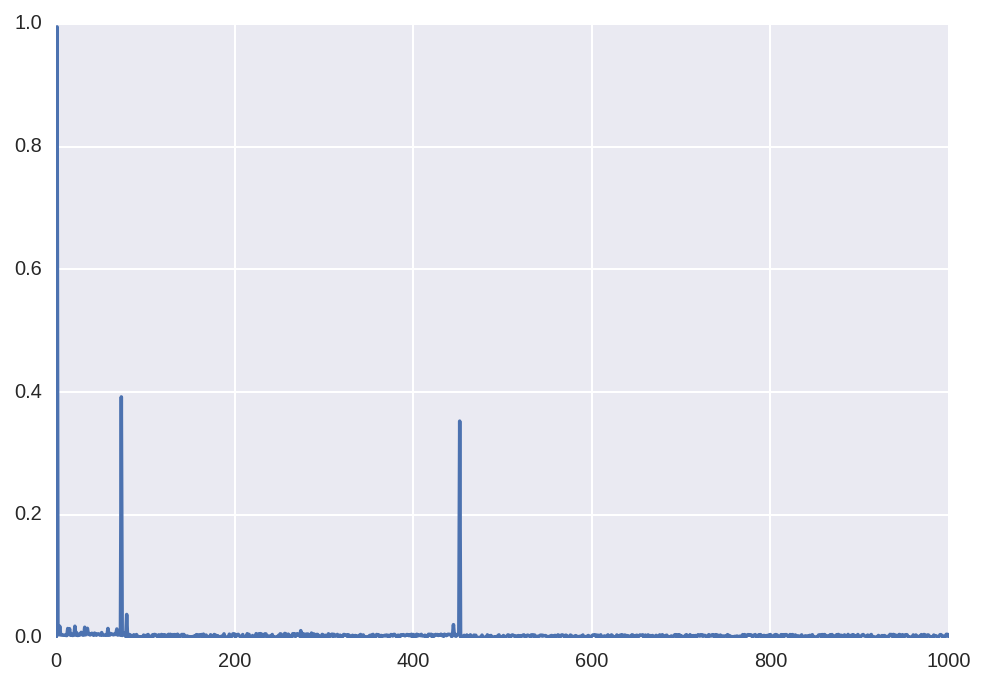

In [10]:
plt.plot(R[1,:])

In [11]:
np.argwhere(R[1,:] > 0.05), CP

(array([[  1],
        [ 73],
        [452]]), [0, 72, 368, 440, 503])

## Online learning

- Models that can update their state bit-by-bit.  Let's them learn as new data come in.
- Bayesian checkpoint is online -- new probs from new datum and existing probs
- Exponential running average is online -- stores very little state.
- Linear regression is not (used for detrending), but SGD is

Example of online model to detect future anomalies

## Exercises

Suggestions?